# Particle identification and energy regression

In [225]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb

## Load dataframe

In [226]:
# DATA_DIR = '/groups/hep/mojen/repositories/DREAM/Run/final_run/tauolaevts/10000'
DATA_DIR = '/home/jupyter/DREAM'
df = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))
print(f"df.shape : {df.shape}")
df.head()

df.shape : (39722, 15)


,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj
0,0,0,1,19816.199882,1825.8025,0.0000,5.811312,NaN,0.042815,NaN,0.000000,2527.482714,1,194.160770,112.979410
1,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362
2,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139
3,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179
4,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211


In [227]:
df['label_binary'] = df.label.map({0: 0, 1: 1, 2: 0, 3: 1})

In [228]:
df.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj,label_binary
0,0,0,1,19816.199882,1825.8025,0.0000,5.811312,NaN,0.042815,NaN,0.000000,2527.482714,1,194.160770,112.979410,1
1,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362,1
2,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139,0
3,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179,0
4,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211,0


<!-- Add column with reconstructed energy -->

In [229]:
# cal = np.load(os.path.join(DATA_DIR, "calibration.pkl.npy"), allow_pickle=True).item()

In [230]:
# df['rec_energy'] = df.apply(lambda x: (x.S_sum-cal['chi']*x.C_sum)/(1-cal['chi']), axis=1)

In [231]:
# print(f"df.shape : {df.shape}")
# df.head()

## Train-test split

Train-test split by event id such that data leakage is avoided and decay classification is possible

In [232]:
unique_eventId = df.eventId.unique()

In [233]:
get_mode = lambda x: x.iloc[0].PrimaryDecayMode.astype(int)
mode_per_eventId = df.groupby('eventId').apply(get_mode).values

In [234]:
id_train, id_test = train_test_split(unique_eventId,
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify=mode_per_eventId)

Assert that id_train and id_test are mutually exclusive and in total have the same size as unique event id

In [235]:
assert len(set(id_train).intersection(set(id_test))) == 0

In [236]:
assert id_train.shape[0] + id_test.shape[0] == len(unique_eventId)

Split dataframe into a train and a test dataframe

In [237]:
excl_columns_y = ['eventId', 'PrimaryDecayMode', 'clusterId', 
                'VecShowerEnergy', 'label', 'label_binary', 
                  'comi', 'comj', 'S_sum', 'C_sum', 'rec_energy']
excl_columns_z = ['eventId', 'PrimaryDecayMode', 'clusterId', 
                'VecShowerEnergy', 'label', 'label_binary', 'comi', 'comj']

# train dataset
df_train = df[df.eventId.isin(id_train)].copy()
df_train.to_csv(os.path.join(DATA_DIR, 'dftrain.csv'), index=False)
y_train = df_train.label_binary.values
z_train = df_train.VecShowerEnergy.values

df_train_y = df_train.drop(excl_columns_y, axis=1)
X_train_y = df_train_y.values
train_data_y = lgb.Dataset(X_train_y, label=y_train, feature_name=list(df_train_y.columns.values))

df_train_z = df_train.drop(excl_columns_z, axis=1)
X_train_z = df_train_z.values
train_data_z = lgb.Dataset(X_train_z, label=z_train, feature_name=list(df_train_z.columns.values))

# test data set
df_test = df[df.eventId.isin(id_test)].copy()
df_test.to_csv(os.path.join(DATA_DIR, 'dftest.csv'), index=False)
idx_test = df_test.clusterId.values.reshape((-1,1))
y_test = df_test.label_binary.values
z_test = df_test.VecShowerEnergy.values

df_test_y = df_test.drop(excl_columns_y, axis=1)
X_test_y = df_test_y.values
test_data_y = lgb.Dataset(X_test_y, label=y_test, feature_name=list(df_test_y.columns.values))

df_test_z = df_test.drop(excl_columns_z, axis=1)
X_test_z = df_test_z.values
test_data_z = lgb.Dataset(X_test_z, label=z_test, feature_name=list(df_test_z.columns.values))

In [238]:
y_test

array([1, 0, 0, ..., 0, 0, 1])

In [239]:
print(f"features classification : {df_train_y.columns.values}")
print(f"features regression : {df_train_z.columns.values}")
assert set(df_train.columns.values) == set(df_test.columns.values)

features classification : ['S_rad_mean' 'C_rad_mean' 'S_hot' 'C_hot' 'CoverS']
features regression : ['S_sum' 'C_sum' 'S_rad_mean' 'C_rad_mean' 'S_hot' 'C_hot' 'CoverS'
 'rec_energy']


In [240]:
print(f"df_train.shape : {df_train.shape}")
print(f"df_test.shape : {df_test.shape}")

df_train.shape : (27761, 16)
df_test.shape : (11961, 16)


Assert that the length of the two dataframes equal the original

In [241]:
assert df_train.shape[0] + df_test.shape[0] == df.shape[0]

# Classification

(Boosted) decision trees 'unaffected' by feature scaling

### Training

In [242]:
params = {
    'num_class': [4],
    'objective': ['multiclass'],  # 'multiclassova'
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1, 0.05],  # default = 0.1
    'num_leaves': [31, 41, 21],  # default = 31
    'metric': ['multi_logloss']
}

In [243]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]
param

[{'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 31,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 41,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 21,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 31,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 41,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 21,
  'metric': 'multi_logloss'}]

In [244]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_y, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=False, seed=42)
    metric_name = param[i]['metric']+"-mean"
    results += [(i, len(cv_results[metric_name]), cv_results[metric_name][-1])]

In [245]:
results.sort(key=lambda x: x[2])
results

[(5, 183, 0.1377601912755571),
 (3, 152, 0.1378386999649167),
 (2, 96, 0.1381015697537487),
 (4, 153, 0.13822514492925375),
 (0, 69, 0.13867573242549622),
 (1, 69, 0.13870447046378737)]

In [246]:
param[results[0][0]]

{'num_class': 4,
 'objective': 'multiclass',
 'boosting': 'gbrt',
 'learning_rate': 0.05,
 'num_leaves': 21,
 'metric': 'multi_logloss'}

In [247]:
bst = lgb.train(param[results[0][0]], train_data_y, num_boost_round=results[0][1])

### Testing

In [248]:
y_pred = np.argmax(bst.predict(X_test_y), axis=1).reshape([-1,1])

In [249]:
confusion_matrix(y_test, y_pred)

array([[7416,  286],
       [ 312, 3947]])

In [250]:
accuracy_score(y_test, y_pred)

0.9500041802524872

In [30]:
df_new = pd.DataFrame(np.hstack((idx_test, y_pred)), columns=['clusterId', 'predictedLabel'])
df_merged = df.merge(df_new, how='inner', on='clusterId')
df_merged

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj,predictedLabel
0,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362,3
1,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139,2
2,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179,2
3,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211,2
4,1,5,4,2466.543425,1842.5836,1791.8718,2.239413,1.640046,0.152792,0.247525,0.972478,1862.072820,2,157.373335,147.430044,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11956,24994,47843,4,23198.037915,20995.1740,20991.4730,2.688260,2.105588,0.180732,0.158891,0.999824,20996.596344,2,142.857341,152.197950,2
11957,24994,47844,4,5323.161134,4377.6500,4204.6826,2.252140,1.775723,0.135529,0.141350,0.960489,4444.123675,2,85.402598,125.760214,2
11958,24997,47850,3,1257.497641,1061.2260,1224.1480,1.792903,1.445399,0.127345,0.224638,1.153522,998.612906,2,111.476039,64.688250,2
11959,24997,47851,3,2065.989166,1842.0273,2102.3413,2.347781,2.146135,0.162746,0.172996,1.141319,1741.985163,2,183.128526,53.747914,2


In [31]:
df_merged.shape

(11961, 16)

In [32]:
df_merged.predictedLabel.isna().sum()

0

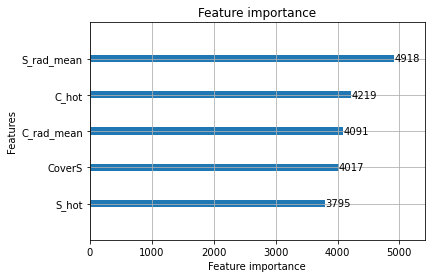

In [33]:
lgb.plot_importance(bst)

In [120]:
from sklearn.inspection import permutation_importance
model = lgb.LGBMClassifier(**param[results[0][0]], n_estimators=results[0][1])
model = model.fit(X_train, y_train)
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{train_data_y.feature_name[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

C_rad_mean0.172 +/- 0.003
C_hot   0.065 +/- 0.002
S_rad_mean0.062 +/- 0.002
CoverS  0.057 +/- 0.002
C_sum   0.050 +/- 0.002
S_hot   0.027 +/- 0.001
rec_energy0.021 +/- 0.002
S_sum   0.015 +/- 0.001


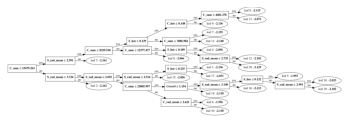

In [121]:
lgb.plot_tree(bst)

## Regression

### Training

In [65]:
params = {
    'objective': ['regression'],
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1, 0.05], # 0.01],  # default = 0.1
    'num_leaves': [31, 21, 41],  # default = 31
    'metric': ['mape'], # 'rmse']
}

In [66]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [67]:
param

[{'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 31,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 21,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 41,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 31,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 21,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 41,
  'metric': 'mape'}]

In [68]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_z, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=False, seed=42, stratified=False)
    metric_name = param[i]['metric']+"-mean"
    results += [(i, len(cv_results[metric_name]), cv_results[metric_name][-1])]

In [69]:
results.sort(key=lambda x: x[2])
results

[(5, 280, 0.3251374166027818),
 (2, 134, 0.32767821370037686),
 (3, 370, 0.3300638374867154),
 (0, 199, 0.3313337137294589),
 (4, 551, 0.3332111111793291),
 (1, 222, 0.336151969045427)]

In [70]:
bst = lgb.train(param[results[0][0]], train_data_z, num_boost_round=results[0][1])

### Testing

In [96]:
z_pred = bst.predict(X_test_z).reshape([-1,1])

In [175]:
z_pred = np.clip(z_pred, 0, 1e6)

In [176]:
df_new2 = pd.DataFrame(np.hstack((idx_test, z_pred)), columns=['clusterId', 'predictedEnergy'])
df_merged2 = df_merged.merge(df_new2, how='inner', on='clusterId')
df_merged2.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj,predictedLabel,predictedEnergy
0,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362,3,15232.819549
1,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139,2,11212.475262
2,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179,2,5538.377130
3,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211,2,11999.057493
4,1,5,4,2466.543425,1842.5836,1791.8718,2.239413,1.640046,0.152792,0.247525,0.972478,1862.072820,2,157.373335,147.430044,2,2427.241780


In [177]:
df_merged2.to_csv(os.path.join(DATA_DIR, 'dfmerged2.csv'), index=False)

In [21]:
import ROOT
from array import array

f = ROOT.TFile( 'test_filling.root', 'recreate' )
t = ROOT.TTree( 't1', 'tree with histos' )
 
d1 = array('d', [0.])
d2 = array('d', [0.])
t.Branch('z_test', d1, "z_test/D")
t.Branch('z_pred', d2, "z_pred/D")
for i in range(len(z_test)):
    d1[0] = z_test[i]
    d2[0] = z_pred[i]
    t.Fill()
f.Write()
f.Close()

In [30]:
d = ROOT.ROOT.RDataFrame("t1", "test_filling.root")

 FCN=126.267 FROM MIGRAD    STATUS=CONVERGED     174 CALLS         175 TOTAL
                     EDM=1.07037e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.45350e+02   2.54135e+01   9.70878e-02   5.52580e-05
   2  Mean         8.72143e+01   7.08781e+00   3.47234e-02  -3.19961e-05
   3  Sigma        2.30661e+02   6.53885e+00   1.67680e-05   4.69551e-01
 FCN=169.608 FROM MIGRAD    STATUS=CONVERGED     211 CALLS         212 TOTAL
                     EDM=5.36691e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.63501e+02   2.40645e+01   1.11221e-01  -1.92411e-06
   2  Mean         7.46872e+01   7.19131e+00   4.54626e-02   3.76746e-05
   3  Sigma        2.71202e+02   

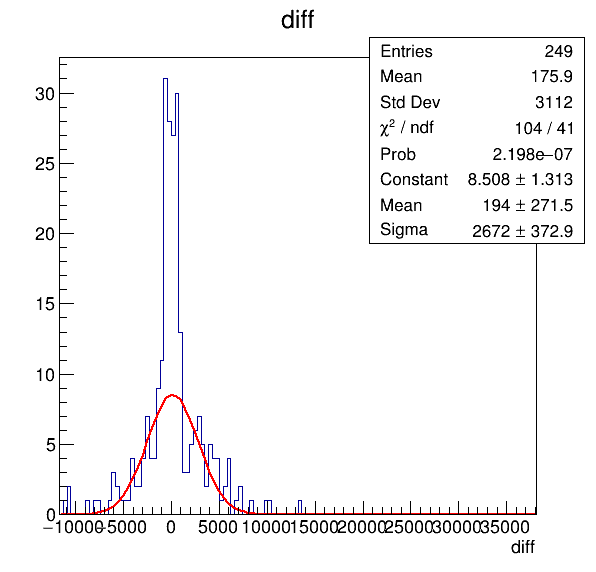

In [84]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
ROOT.gStyle.SetOptFit(1111)

binwidth = 2000
nbins = 10
data = {k: np.zeros(nbins) for k in ['Energy', 'EnergyRes', 'EnergyResErr']}
for i in range(nbins):
    d2 = d.Filter(f"z_test > {binwidth*i} && z_test < {binwidth*(i+1)}")
    if d2.Count().GetValue() < 200:
        break
    
    d2 = d2.Define("diff", "z_pred-z_test")
    h = d2.Histo1D("diff")
    h.DrawCopy()
    r = h.Fit("gaus", "S")
    data['Energy'][i] = (i+0.5)*binwidth*1e-3
    data['EnergyRes'][i] = r.Parameter(2)/((i+0.5)*binwidth+r.Parameter(1))
    data['EnergyResErr'][i] = data['EnergyRes'][i]*(r.ParError(1)/r.Parameter(1)+r.ParError(2)/r.Parameter(2))
c1.Draw()

 FCN=1.65303 FROM MIGRAD    STATUS=CONVERGED      34 CALLS          35 TOTAL
                     EDM=6.28276e-23    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.56298e-01   5.22502e-02   1.14348e-05  -7.76730e-10
   2  p1          -5.44663e-02   3.40593e-02   7.45380e-06  -1.11710e-09


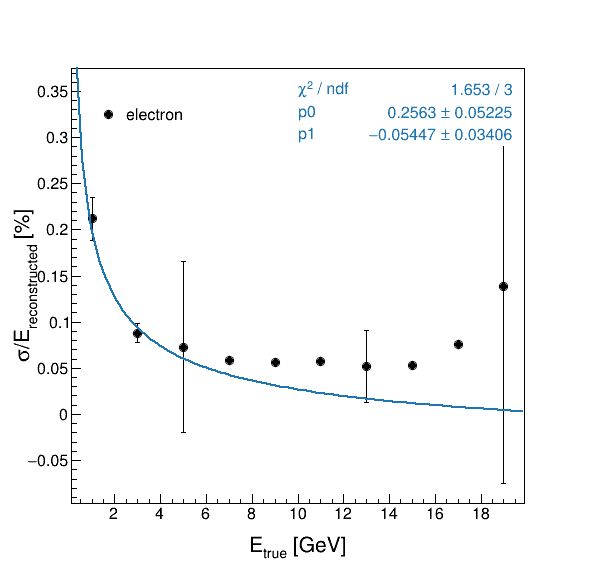

In [85]:
from tableauColors import palette


ROOT.gStyle.SetOptStat("emr")
ROOT.gStyle.SetOptFit(1)

c2 = ROOT.TCanvas("c2", "c2", 600, 600)
c2.SetLeftMargin(.12)
c2.SetBottomMargin(.12)
c2.SetRightMargin(.12)
c2.SetTopMargin(.12)

mg = ROOT.TMultiGraph()
gr = [None, None]
f1 = [None, None]
f1[0] = ROOT.TF1("f1","[0]/sqrt(x)+[1]")
f1[1] = f1[0].Clone()
f1[0].SetLineColor(palette['blue'].GetNumber())
f1[1].SetLineColor(palette['red'].GetNumber())
marker = [ROOT.kFullDotLarge, ROOT.kFullTriangleUp]

i = 0
# for i,s in enumerate(['e', 'pi']):
x = array('f', data['Energy'])
n = len(x)
y = array('f', data['EnergyRes'])
ex = array('f', [0.]*n)
ey = array('f', data['EnergyResErr'])
gr = ROOT.TGraphErrors(n, x, y, ex, ey)
gr.Fit(f1[i], "S")
gr.SetMarkerStyle(marker[i])

mg.Add(gr)
mg.Draw('ap')

c2.Update()

labelsize = 0.03
titlesize = 0.04
titleoffset = 1.2
labeloffset = 0.005
linewidth = 3
ticklength = 0.02

mg.GetXaxis().SetTitle("E_{true} [GeV]")
mg.GetYaxis().SetTitle("#sigma/E_{reconstructed} [%]")
# mg.SetMinimum(0.)
# mg.SetMaximum(16.)
mg.GetXaxis().SetTickLength(ticklength)
mg.GetYaxis().SetTickLength(ticklength)
mg.GetXaxis().SetTitleSize(titlesize)
mg.GetYaxis().SetTitleSize(titlesize)
mg.GetXaxis().SetLabelSize(labelsize)
mg.GetYaxis().SetLabelSize(labelsize)
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.GetXaxis().SetTitleOffset(titleoffset)
mg.GetYaxis().SetTitleOffset(titleoffset)
mg.GetXaxis().SetLabelOffset(labeloffset)
mg.GetYaxis().SetLabelOffset(labeloffset)

stats1 = gr.GetListOfFunctions().FindObject("stats")
# stats2 = gr[1].GetListOfFunctions().FindObject("stats")
stats1.SetTextColor(palette['blue'].GetNumber())
# stats2.SetTextColor(palette['red'].GetNumber())
stats1.SetX2NDC(1-c2.GetRightMargin()); stats1.SetX1NDC(stats1.GetX2NDC()-0.4)
stats1.SetY2NDC(1-c2.GetTopMargin()-0.016); stats1.SetY1NDC(stats1.GetY2NDC()-0.12)
# stats2.SetX2NDC(stats1.GetX2NDC()); stats2.SetX1NDC(stats1.GetX1NDC())
# stats2.SetY2NDC(stats1.GetY1NDC()); stats2.SetY1NDC(stats2.GetY2NDC()-0.12)
stats1.SetTextSize(labelsize)
# stats2.SetTextSize(labelsize)
stats1.SetBorderSize(0)
# stats2.SetBorderSize(0)

# add legend
x1 = c2.GetLeftMargin() + 0.03
x2 = x1 + 0.25
y2 = 1 - c2.GetTopMargin() - 0.03 - 0.01
y1 = y2 - 0.08
legend = ROOT.TLegend(x1, y1, x2, y2)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(gr, "electron", "p")
# legend.AddEntry(gr[1], "pion", "p")
legend.Draw()

c2.Modified()
c2.Print("energyres.png")
c2.Draw()

In [71]:
z_pred, z_test

(array([24946.6309341 ,  1404.45580374,  1035.06862257, ...,
         1371.90180059,  8863.42131498,  6544.48131989]),
 array([21408.33540089,   924.50801965,  1100.24599705, ...,
         1546.25015299,  9001.60140181,  6665.59402163]))

1006


(array([  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   2.,   1.,   0.,   2.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   3.,   5.,
          2.,   4.,   2.,   1.,   7.,  18.,  61., 181., 466., 215.,  19.,
          3.,   1.,   0.,   1.,   0.,   1.]),
 array([-10009.72150301,  -9769.20929351,  -9528.69708401,  -9288.1848745 ,
         -9047.672665  ,  -8807.1604555 ,  -8566.648246  ,  -8326.1360365 ,
         -8085.62382699,  -7845.11161749,  -7604.59940799,  -7364.08719849,
         -7123.57498899,  -6883.06277948,  -6642.55056998,  -6402.03836048,
         -6161.52615098,  -5921.01394148,  -5680.50173197,  -5439.98952247,
         -5199.47731297,  -4958.96510347,  -4718.45289397,  -4477.94068446,
         -4237.42847496,  -3996.91626546,  -3756.40405596,  -3515.89184646,
         -3275.37963695,  -3034.86742745,  -2794.35521795,  -2553.84300845,
         -2313.33079895,  -2072.81858944,  -1832.3

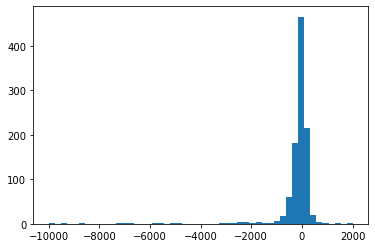

In [112]:
cond = np.bitwise_and(z_test > 1000, z_test < 2000)
z_test[cond]
print(len(z_test[cond]))
plt.hist(z_test[cond] - z_pred[cond], bins=50)

In [73]:
np.mean(np.abs(z_test - z_pred) / z_test)

0.19300961070466618

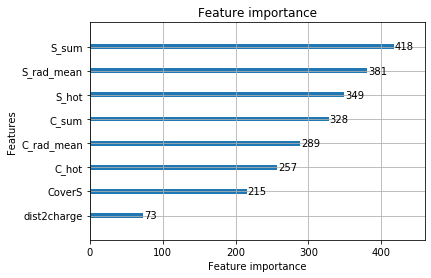

In [74]:
lgb.plot_importance(bst)

ImportError: cannot import name 'Digraph'

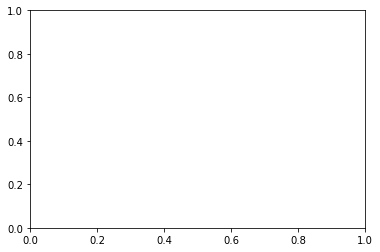

In [29]:
lgb.plot_tree(bst)

## Pion reconstruction

In [178]:
import itertools
from scipy import spatial

def pionReconstruction(df):
    m_true = 134.9770
    df_gamma = df[df.predictedLabel == 2]
    if df_gamma.shape[0] >= 2:  # two or more photons
        indices = df_gamma.index.values
        pairs = list(map(list, itertools.combinations(indices, 2)))
        d = {'[]': m_true}
        for p in pairs:
            df_gamma_pair = df_gamma.loc[p]
            f1 = lambda x: np.sqrt((x.comi_mm-0)**2+(x.comj_mm-0)**2+(2500-0)**2)
            df_gamma_pair['vlen'] = df_gamma_pair.apply(f1, axis=1)
            num = df_gamma_pair.comi_mm.product() + df_gamma_pair.comj_mm.product() + 2500**2
            denom = df_gamma_pair.vlen.product()
            cos_theta = np.clip(num / denom, 0, 1)
            mass = np.sqrt(2*df_gamma_pair.predictedEnergy.product()*(1-cos_theta))
            d[str(p)] = mass
        pair_of_pairs = list(map(list, itertools.combinations(pairs, 2)))

        p_lst = [p for p in pair_of_pairs if len(set(p[0]+p[1])) == 4]
        
        if len(p_lst) == 0:
            p_lst = [[pairs[0], []]]
        
        metric = []
        for p in p_lst:
            metric += [np.sqrt((d[str(p[0])]-m_true)**2 + (d[str(p[1])]-m_true)**2)]
        best_idx = np.argsort(metric)[0]
        
        for p in p_lst[best_idx]:
            if len(p) != 0:
                df.at[p[0], 'pair'] = p
                df.at[p[1], 'pair'] = p
                df.at[p[0], 'predicted_pi0_mass'] = d[str(p)]
                df.at[p[1], 'predicted_pi0_mass'] = d[str(p)]
        
    return df

In [179]:
df_merged2.predictedEnergy.min()

0.0

In [180]:
# df_merged2 = df_merged.copy()
df_merged2['comi_mm'] = df_merged2.apply(lambda x: 3*(x.comi-284+0.5), axis=1)
df_merged2['comj_mm'] = df_merged2.apply(lambda x: 3*(x.comj-284+0.5), axis=1)
df_merged2['pair'] = None
df_merged2['predicted_pi0_mass'] = None
df_merged3 = df_merged2.groupby('eventId').apply(pionReconstruction)

In [181]:
df_merged3.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,...,rec_energy,label,comi,comj,predictedLabel,predictedEnergy,comi_mm,comj_mm,pair,predicted_pi0_mass
0,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,...,7375.418953,3,124.308455,127.515362,3,15232.819549,-477.574634,-467.953913,None,None
1,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,...,11375.182248,2,135.292237,180.123139,2,11212.475262,-444.623289,-310.130582,"[1, 2]",148.864
2,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,...,5377.132679,2,150.901608,175.728179,2,5538.377130,-397.795177,-323.315464,"[1, 2]",148.864
3,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,...,10502.665935,2,138.046102,156.708211,2,11999.057493,-436.361693,-380.375367,"[3, 4]",134.992
4,1,5,4,2466.543425,1842.5836,1791.8718,2.239413,1.640046,0.152792,0.247525,...,1862.072820,2,157.373335,147.430044,2,2427.241780,-378.379995,-408.209869,"[3, 4]",134.992


In [184]:
df_merged3.reset_index(drop=True, inplace=True)

In [185]:
df_merged4 = df_merged3.copy()
df_merged4 = df_merged4[["pair","predicted_pi0_mass"]].reset_index(drop=True)
df_merged4.pair = df_merged4.pair.astype('str')
df_merged4 = df_merged4.drop_duplicates()
df_merged4.to_csv(os.path.join(DATA_DIR, 'predicted_pi0_mass.csv'), index=False)

## Decay classification

In [186]:
def decayClassification(x):
    counts_label = x.predictedLabel.value_counts()
    counts_pair = x.pair.unique() 
    num_pairs = len([p for p in counts_pair if p != 'None'])
    mode = np.nan
    if 0 in counts_label.keys():
        mode = 0
    elif 1 in counts_label.keys():
        mode = 1
    elif 3 in counts_label.keys() and num_pairs <= 2:
        mode = 2
        if num_pairs == 1:
            mode = 3
        elif num_pairs == 2:
            mode = 4
    elif 2 in counts_label.keys():
        mode = 5
    x['predictedPrimaryDecayMode'] = mode
    return x

In [187]:
df_merged3.pair = df_merged3.pair.astype("str")
df_merged5 = df_merged3.groupby('eventId').apply(decayClassification)

array([4, 3])

In [158]:
# df_merged2.predictedPrimaryDecayMode.isna().sum()

In [188]:
mode_per_eventId = df_merged5.groupby('eventId').apply(get_mode)
get_predmode = lambda x: x.iloc[0].predictedPrimaryDecayMode.astype(int)
predmode_per_eventId = df_merged5.groupby('eventId').apply(get_predmode)

In [189]:
confusion_matrix = pd.crosstab(mode_per_eventId, #df_merged2.PrimaryDecayMode, 
                               predmode_per_eventId, #df_merged2.predictedPrimaryDecayMode, 
                               rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted    0    1     2    3    4     5
Actual                                   
0          377    2     4    0    0  1026
1            2  355   454    0    0   161
2           12   30  1234    0    0    52
3          131   64   256  615    0   269
4          140   67    35  435  244   275


In [190]:
assert np.sum(confusion_matrix.values) == df_merged5.shape[0]

AssertionError: 

In [193]:
accuracy_score(mode_per_eventId, predmode_per_eventId)

0.452724358974359

In [34]:
df_merged3 = df_merged2[df_merged2.PrimaryDecayMode.isin([2,3,4]) & df_merged2.predictedPrimaryDecayMode.isin([2,3,4,5])]

In [35]:
accuracy_score(df_merged3.PrimaryDecayMode.values, df_merged3.predictedPrimaryDecayMode.values)

0.6404998397949375